In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from ast import literal_eval

In [1]:
path = os.path.join("..", "data")

# load the movie metadata
df_moviesmetadata=pd.read_csv(path + 'movies_metadata.csv', low_memory=False) 
print(df_moviesmetadata.shape)
print(df_moviesmetadata.columns)
df_moviesmetadata.head(2)

(45466, 24)
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [2]:
# load the movie ratings
df_ratings=pd.read_csv(path + 'ratings_small.csv', low_memory=False) 

print(df_ratings.shape)
print(df_ratings.columns)
df_ratings.head(3)



(100004, 4)
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


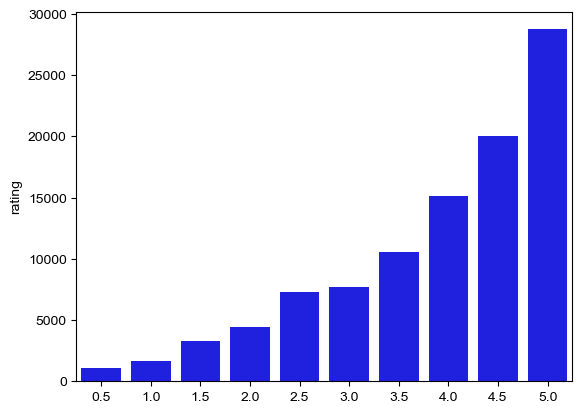

In [3]:
rankings_count = df_ratings.rating.value_counts().sort_values()
sns.barplot(x=rankings_count.index.sort_values(), y=rankings_count, color="b")
sns.set_theme(style="whitegrid")

# Cleaning the Data

In [4]:
# remove invalid records with invalid ids
df_mmeta = df_moviesmetadata.drop([19730, 29503, 35587])

df_movies = pd.DataFrame()
df_movies = df_moviesmetadata['title']
df_movies['year'] = pd.to_datetime(df_mmeta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

df_movies.head()

C:\Users\User\AppData\Local\Temp\ipykernel_17184\604640403.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['year'] = pd.to_datetime(df_mmeta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
Name: title, dtype: object

In [15]:
# remove invalid records with invalid ids
df_mmeta = df_moviesmetadata.drop([19730, 29503, 35587])

df_movies = pd.DataFrame()
df_movies=pd.DataFrame(df_mmeta['title'])

# extract the release year 
df_movies['year'] = pd.to_datetime(df_mmeta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# extract genres
df_movies['genres'] = df_mmeta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# change the index to movie_id
df_movies['movieId'] = pd.to_numeric(df_mmeta['id'])
df_movies = df_movies.set_index('movieId')


In [16]:
print(df_movies.columns)
print(df_mmeta.columns)


Index(['title', 'year', 'genres'], dtype='object')
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [17]:
merged_df = pd.merge(df_movies, df_mmeta, on='title', how='inner')
merged_df.head()

,title,year,genres_x,adult,belongs_to_collection,budget,genres_y,homepage,id,imdb_id,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,video,vote_average,vote_count
0,Toy Story,1995,"[Animation, Comedy, Family]",False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,False,7.7,5415.0
1,Jumanji,1995,"[Adventure, Fantasy, Family]",False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,False,6.9,2413.0
2,Grumpier Old Men,1995,"[Romance, Comedy]",False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,False,6.5,92.0
3,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,False,6.1,34.0
4,Father of the Bride Part II,1995,[Comedy],False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,False,5.7,173.0


In [19]:
df_movies_new = merged_df.loc[:, ['id','title', 'year', 'genres_x','vote_average','vote_count']]
df_movies_new.head()



,id,title,year,genres_x,vote_average,vote_count
0,862,Toy Story,1995,"[Animation, Comedy, Family]",7.7,5415.0
1,8844,Jumanji,1995,"[Adventure, Fantasy, Family]",6.9,2413.0
2,15602,Grumpier Old Men,1995,"[Romance, Comedy]",6.5,92.0
3,31357,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",6.1,34.0
4,11862,Father of the Bride Part II,1995,[Comedy],5.7,173.0


In [25]:

df_mov = df_movies_new.rename(columns={'genres_x': 'genres','id':'movieId'})
df_mov.head()

,movieId,title,year,genres,vote_average,vote_count
0,862,Toy Story,1995,"[Animation, Comedy, Family]",7.7,5415.0
1,8844,Jumanji,1995,"[Adventure, Fantasy, Family]",6.9,2413.0
2,15602,Grumpier Old Men,1995,"[Romance, Comedy]",6.5,92.0
3,31357,Waiting to Exhale,1995,"[Comedy, Drama, Romance]",6.1,34.0
4,11862,Father of the Bride Part II,1995,[Comedy],5.7,173.0


In [26]:
# drop na values
df_ratings_temp = df_ratings.dropna()

# convert datetime
df_ratings_temp['timestamp'] = pd. to_datetime(df_ratings_temp['timestamp'], unit='s')

print(f'unique users: {len(df_ratings_temp.userId.unique())}, ratings: {len(df_ratings_temp)}')
df_ratings_temp.head()

unique users: 671, ratings: 100004


,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


In [27]:
# The Reader class is used to parse a file containing ratings.
# The file is assumed to specify only one rating per line, such as in the df_ratings_temp file above.
reader = Reader()
ratings_by_users = Dataset.load_from_df(df_ratings_temp[['userId', 'movieId', 'rating']], reader)

# Split the Data into train and test
train_df, test_df = train_test_split(ratings_by_users, test_size=.2)

In [28]:
# train an SVD model
svd_model = SVD()
svd_model_trained = svd_model.fit(train_df)

<Axes: ylabel='Mean Absolute Error'>

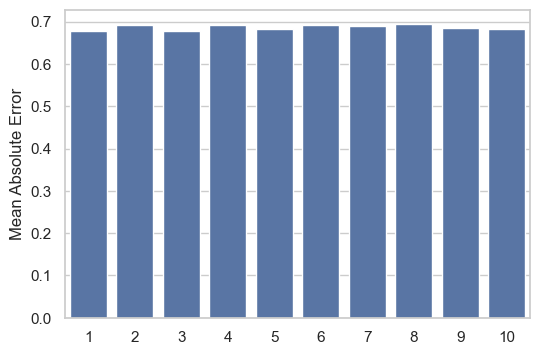

In [29]:
# 10-fold cross validation 
cross_val_results = cross_validate(svd_model_trained, ratings_by_users, measures=['RMSE', 'MAE', 'MSE'], cv=10, verbose=False)
test_mae = cross_val_results['test_mae']

# mean squared errors per fold
df_test_mae = pd.DataFrame(test_mae, columns=['Mean Absolute Error'])
df_test_mae.index = np.arange(1, len(df_test_mae) + 1)
df_test_mae.sort_values(by='Mean Absolute Error', ascending=False).head(15)

# plot an overview of the performance per fold
plt.figure(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.barplot(y='Mean Absolute Error', x=df_test_mae.index, data=df_test_mae, color="b")
# plt.title('Mean Absolute Error')

In [32]:
# predict ratings for a single user_id and for all movies
user_id = 400 # some test user from the ratings file

# create the predictions
pred_series= []
df_ratings_filtered = df_ratings[df_ratings['userId'] == user_id]

print(f'number of ratings: {df_ratings_filtered.shape[0]}')
for movie_id, name in zip(df_mov.index, df_mov['title']):
    # check if the user has already rated a specific movie from the list
    rating_real = df_ratings.query(f'movieId == {movie_id}')['rating'].values[0] if movie_id in df_ratings_filtered['movieId'].values else 0
    # generate the prediction
    rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=False)
    # add the prediction to the list of predictions
    pred_series.append([movie_id, name, rating_pred.est, rating_real])

# print the results
df_recommendations = pd.DataFrame(pred_series, columns=['movieId', 'title', 'predicted_rating', 'actual_rating'])
df_recommendations.sort_values(by='predicted_rating', ascending=False).head(15)

number of ratings: 58


,movieId,title,predicted_rating,actual_rating
1203,1203,Bread and Chocolate,4.651839,0.0
50,50,Leaving Las Vegas,4.629470,4.0
296,296,Casper,4.573263,4.0
3462,3462,Fallen,4.572634,0.0
926,926,The Secret Garden,4.564154,0.0
858,858,Much Ado About Nothing,4.558775,0.0
750,750,Black Beauty,4.553784,0.0
969,969,The Three Musketeers,4.537207,0.0
994,994,The Three Musketeers,4.534625,0.0
2064,2064,Cinderella,4.520438,0.0


In [34]:
# predict ratings for the combination of user_id and movie_id
user_id = 217 # some test user from the ratings file
movie_id = 4002
rating_real = df_ratings.query(f'movieId == {movie_id} & userId == {user_id}')['rating'].values[0]
movie_title = df_mov[df_mov.index == 862]['title'].values[0]

print(f'Movie title: {movie_title}')
print(f'Actual rating: {rating_real}')

# predict and show the result
rating_pred = svd_model_trained.predict(user_id, movie_id, rating_real, verbose=True)

Movie title: Much Ado About Nothing
Actual rating: 4.5
user: 217        item: 4002       r_ui = 4.50   est = 4.17   {'was_impossible': False}
